# Bitcoin network - Project

#### Lysenko Oleksandr


## Introduction

At the time the white paper of Bitcoin was published it was nothing but a dream for nerds with a few of them using it. As time passed Bitcoin's network scaled up firstly to become accepted as a pizza payment up to the point where it can quite succesfully serve as a mean of payments.  
Network effect is essential for an asset like Bitcoin to exist. If noone recognizes and uses it - the cryptocurrency stays nothing but a promising technology. Therefore, Ifind it important to look at the Bitcoin network not around the specific event which would raise the transaction volume; but on a normal day to discover how the transactions are executed, who and for what purposes is using the Bitcoin. 

In the project I apply the methods of networking analysis on the first 10 000 transactions in September 2016. In addition to that I want to identify the most important nodes in the network using different centralities measures. For that last purpose I deploy a different dataset of last 1 Million transactions in the database [availabe here](http://cazabetremy.fr/Teaching/BitcoinNetwork.html) 


## Data preprocessing and description

In [2]:
import pandas as pd
import os 
os.chdir('C:/Users/Alexandr/OneDrive/Documents/Network analysis')
rawdata = pd.read_csv("first10kSept2016.csv")
df = rawdata[rawdata["source"]!=rawdata["target"]]
df = df[df.value > 0]

Elimination of the self-transactions and a couple of zero-value transactions left us with 7919 transactions in the dataset. All of them are almost equally distributed between the two timestamps therefore as a first pattern detection I compare the desctiptive statistics of the transactions for these two timestamps.

In [3]:
gb = df.groupby(['timestamp'])
counts = gb.size().to_frame(name='counts') 
counts = (counts.join(gb.agg({'value': 'mean'}).rename(columns={'value': 'value_mean'}))) 
counts = (counts.merge(gb.agg({'value': 'sum'}), on = 'timestamp', how = 'right').rename(columns={'value': 'value_sum'}))
counts = (counts.merge(gb.agg({'valueDoll': 'mean'}), on = 'timestamp', how = 'right').rename(columns={'valueDoll': 'valueDoll_mean'}))
counts = (counts.merge(gb.agg({'valueDoll': 'sum'}), on = 'timestamp', how = 'right').rename(columns={'valueDoll': 'valueDoll_sum'}))
counts

,counts,value_mean,value_sum,valueDoll_mean,valueDoll_sum
timestamp,,,,,
1472691892,3576,2.012678,7197.338077,1150.628133,4.114646e+06
1472693102,4343,2.571892,11169.725954,1470.324806,6.385621e+06


From the table above we see that there were almost 1k more transactions recorded on the block executed on 1 September 2016 at 1:25:02 than on the 20m younger one. Moreover the mean value of each transaction was 25% higher. If the main purpose of Bitcoin was to serve as a mean of payments the number of transactions and its mean value would be relative stable. However, even though we can't make any conclusions from comparing only 2 blocks - the huge scope of literature on Bitcoin and empirical observations clearly state that its possible usage for payments is dominated by many other applications.

## General statistics

So we start with describing undirected, unweighted graph which is the simplest type of graph possible. In our dataset the nodes are the wallets which have sent at least one non-zero Bitcoin transaction during the studied period. The edge in turn forms if there was at least one transaction between two wallet numbers. The very first statistics we observe is about the number of nodes which in our case is equal to 7200 and the number of edges is 7073. That statistics shows that most of the transactions in our dataset are unique. 

Secondly we observe that average degree is less than 2. So every node on average has less than 2 neigboors. Density, which for the undirected graph is computed as $d = \frac{2E}{V(V-1)}$ is equal to $2.73*e^{-4}$ in our case. Both these measurements state that we are dealing with relatively badly connected network especially comparing to other networks of similar size. However, that makes sense for the very small random sample of Bitcoin transactions. There is no reason to expect strong connections in that case. Nevertheless, we beleive that it will still be possible to detect communities by clustering the wallets.

In [4]:
import networkx as nx
G = nx.from_pandas_edgelist(df)
inf = nx.info(G)
d = nx.density(G)
clustering = nx.algorithms.cluster.average_clustering(G)
path_length = nx.algorithms.shortest_paths.generic.shortest_path_length(G)
transitivity=nx.transitivity(G)
local_clust = nx.average_clustering(G)
print(inf.strip('Name:'))
print('Density  = {:.2e}'.format( d))
print('Global clustering coefficient  = {:.2e}'.format( transitivity))
print('Local clustering coefficient  = {:.2e}'.format( local_clust))
print('Average distance  = {}'.format( path_length))

 
Type: Graph
Number of nodes: 7200
Number of edges: 7073
Average degree:   1.9647
Density  = 2.73e-04
Global clustering coefficient  = 9.89e-03
Local clustering coefficient  = 1.81e-02
Average distance  = <generator object all_pairs_shortest_path_length at 0x000001A686D94408>


## Components

Since the majority of our dataset consist of random transaction we expect to have huge scop of nodes to be only connected by pairs. So, one sender will be connected with one receiver. To verify the validity of the assumtuptions we use the componets analysis presented below.


Number of connected components = 844


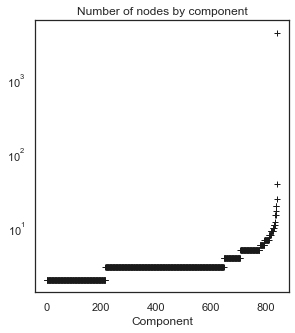

Percentage of nodes in component (Top 5) :  [ 0.27777778  0.27777778  0.34722222  0.54166667 59.58333333] (%)


In [50]:
import matplotlib.pyplot as plt
import numpy as np

Comp = nx.connected_components(G)
S = [G.subgraph(c).copy() for c in Comp]
S.sort(key=len)
print('Number of connected components = {}'.format(len(S)))
Comp_size = [len(sub_comp) for sub_comp in S]
plt.figure(figsize=(10,5))
plt.subplot(122)
plt.plot(Comp_size,'k+')
plt.title('Number of nodes by component')
plt.xlabel('Component')
plt.yscale('log')
plt.show()
print('Percentage of nodes in component (Top {}) : '.format(n), np.array(Comp_size[-n:])/V*100,'(%)')

The results above fully confirm our assumtion. Most of the components indeed contain only 2 nodes and correspond to a single transaction between the users. Interestingly however, we observe a giant component linking together more than a half of the transaction.

To get the visual representation of the network we refer to Gephi. We spacialize the graph using the Force Atlas 2 layout. The priniple is that nodes repell each other and edges act as springs between the nodes. The result is a clear separation between the connected components and eventually a segregation between different dense communities

![alt text](Graph1.png "title")


From the visual representation we again see the existance of the giant connected component found above. 

## Distribution of degrees 

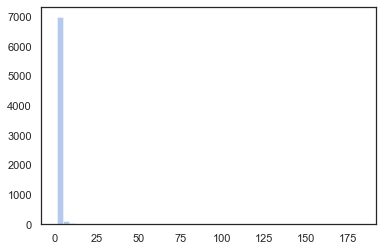

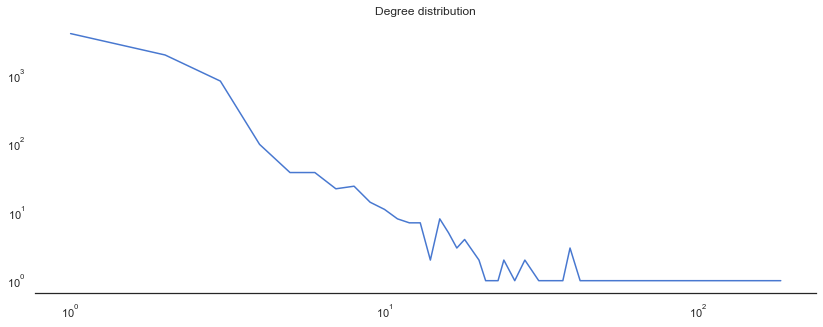

[   1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    3    1    1    1    1    2    1    2    1    1    1    2    4
    3    5    8    2    7    7    8   11   14   24   22   38   38   98
  824 1983 4072]


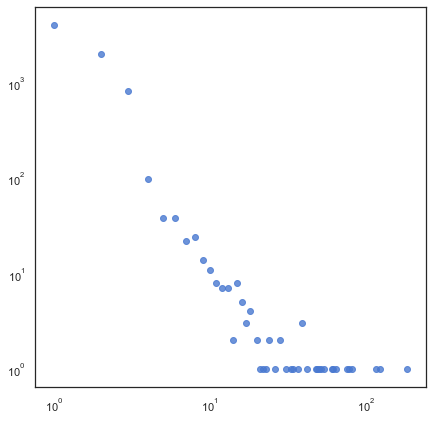

In [53]:
import seaborn as sns
from collections import Counter
#Degree distribution 1.
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
sns.distplot(degree_sequence, kde=False, rug=False);


sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(14, 5), sharex=True)

sns.despine(left=True)

#Degree distribution 2.
axes.set_title('Degree distribution')
axes.set_xscale('log')
axes.set_yscale('log')
degrees = [G.degree(n) for n in G.nodes()]
c = Counter(degrees)
x = list(c.keys())
y = list(c.values())
sns.lineplot(x=x, y=y, color="b",ax=axes)

plt.show()
#Degree distribution 3.
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
deg = np.array(list(deg))
cnt = np.array(list(cnt))
print(cnt)
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.regplot(deg,cnt,fit_reg=False)

The conclusion from first two graphs is that we don't have a normal distribution. In fact, the overwhelming majority of the degree distribution is centered around $10^{2}$ with a very rapid decline and absence of tails. Low degree nodes are by far morore common than high degree nodes. 

The third graph is log-log plot. That plot allows to visually inspect whether we have power-law distribution of degrees which could be expected for "real-world" networks. In the current experiment, we can see a kind of apparent linear relation in the log-log plot which is an evidence in favor of power-law distribution. However, it would be rather reckless to draw the conclusion based solely on that fact as further statistical proves, which are omitted in the current project, are required. 

## Communites 

In order to characterize the topology of our network we use the most classical tool and detect the communities. There're a couple of algorithms developed for this purpose among which Louvain modularity is one of the simplest and the most convininet for our purposes. 

In [7]:
import community


partition = community.best_partition(G)

size = float(len(set(partition.values())))
print('{} communities found, with modularity {}'.format(int(size),community.modularity(partition,G)))

879 communities found, with modularity 0.9211620112678753


We see that the algorithm has found 879 communities with modularity around 0.9 which is a really large number. That means that the network is organized in groups of less than 10 nodes on average. Apart from resulting in messy graphical representation this also proves that these 10k transactions are not structured and the majority of them happened between random people. 

At that stage we refer to Gephi again plotting the network with detected communities. We use the same type of spacialization as in the previous case. The graph is colored by community and sized by betweenness centrality.

![alt text](Graph2.png "title")


# Centralities

That part of the project is dedicated to deploying different methods of measuring centralities in the network. Centrality  tools are useful to look at individual nodes properties, to identify which one are more "central", ie important. Since we find the current dataset of 10k Bitcoin transactions to be too small for identifying the central players of the network - for that part of the project we use the dataset of last 1 million transactions in the database. We eleminate self-transactions, keep only identified players and transactions with higher than 1 Bitcoin value.

In [19]:
rawdata2 = pd.read_csv("trx_last_1M.csv")
rawdata2.columns = ["source","target","timestamp","value","valueDoll"]
df2 = rawdata2[rawdata2["source"]!=rawdata2["target"]]
df2 = df2[df2.value > 1]
df2 = df2[(~df2["source"].astype(str).str.isnumeric()) &  (~df2["target"].astype(str).str.isnumeric())]

G = nx.from_pandas_edgelist(df2)
inf = nx.info(G)
print(inf.strip('Name:'))


 
Type: Graph
Number of nodes: 126
Number of edges: 369
Average degree:   5.8571


The dataset filtered to keep only "important" players of the market shows much smaller amount of nodes and edges comparing to the previous one. The barrier of 1 Bitcoin has excluded a huge scope of transactions from the dataset which proves that the cryptocurrency is, nevertheless, important for small payments, donations etc. We also see that average degree of the current network is equal to 5.85. This means that each node has on average almost 6 neighboors, which is much higher than the one in the previous dataset. Big players trade among each other quite frequently and are likely to form clusters.

## Eigenvector centrality and PageRank

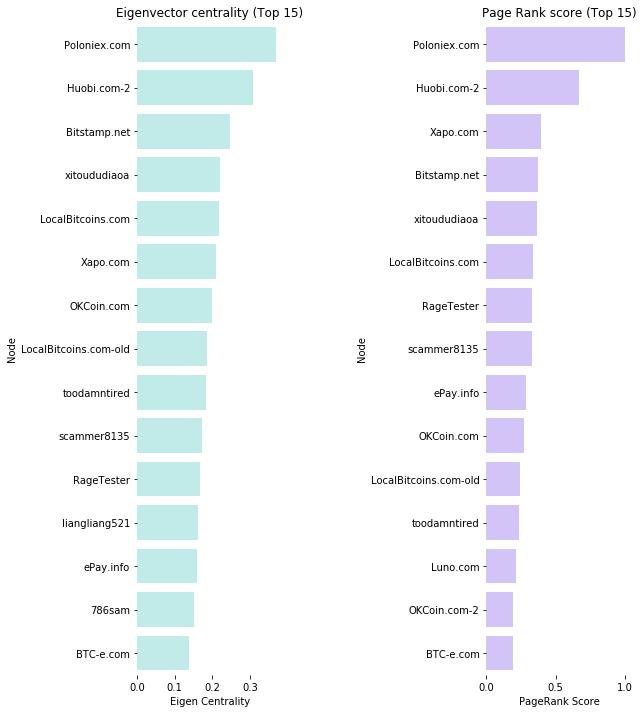

In [26]:
import networkx.algorithms.centrality as nxc
n=15 
eig_c = nxc.eigenvector_centrality_numpy(G)
eig_sequence = sorted([[key,eig_c[key]] for key in eig_c.keys()], key=lambda t: t[1], reverse=True) 
eig_val = [d for n,d in eig_sequence]
eig_nodes = [n for n,d in eig_sequence]
dat_eig = pd.DataFrame.from_dict({'Node' : eig_nodes[0:n], 'Eigen Centrality' : eig_val[0:n]})

pr_c = nx.algorithms.link_analysis.pagerank_alg.pagerank(G)
pr_sequence = sorted([[key,pr_c[key]] for key in pr_c.keys()], key=lambda t: t[1], reverse=True) 
pr_val = np.array([d for n,d in pr_sequence])/pr_sequence[0][1]
pr_nodes = [n for n,d in pr_sequence]
dat_pr = pd.DataFrame.from_dict({'Node' : pr_nodes[0:n], 'PageRank Score' : pr_val[0:n]})

plt.figure(figsize=(12,12))
plt.subplot(142)
plt.title('Eigenvector centrality (Top {})'.format(n))
sns.set_color_codes("pastel")
sns.barplot(x="Eigen Centrality", y="Node", data=dat_eig, label="Total", color="c")
plt.subplot(144)
plt.title('Page Rank score (Top {})'.format(n))
sns.barplot(x="PageRank Score", y="Node", data=dat_pr,label="Total", color="m")
sns.despine(left=True, bottom=True)
plt.show()

Both Eigenvector centrality and PageRank score provide us with similar results regarding the importance of the nodes. According to these centrality measures Poloniex.com and Huobi.com-2 were the most important players on the Bitcoin market over the analyzed period. Importance of the rest of the nodes is essentially the same for both of the centrality measures, even though their rank is slightly shuffled. 

## Betweenness centrality

We also separetely look betweenness centrality measure. It is based on the number of shortest path passing through a node. This centrality measure helps to understand if the node is an important bridge in the network. That's why usually in the graphical representation the size of the nodes is usually ranked according to its betwenness centrality.

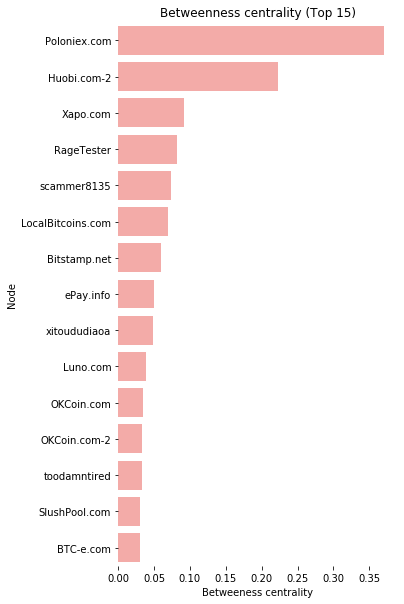

In [30]:
n=15
bet_c = nxc.betweenness_centrality(G)
bet_sequence = sorted([[key,bet_c[key]] for key in bet_c.keys()], key=lambda t: t[1], reverse=True) 
bet_val = [d for n,d in bet_sequence]
bet_nodes = [n for n,d in bet_sequence]
dat_bet = pd.DataFrame.from_dict({'Node' : bet_nodes[0:n], 'Betweeness centrality' : bet_val[0:n]})

plt.figure(figsize=(5,10))
plt.title('Betweenness centrality (Top {})'.format(n))
sns.barplot(y="Node", x="Betweeness centrality", data=dat_bet,label="Total", color="r")
sns.despine(left=True, bottom=True)
plt.show()

The betweenness centrality measure gives us the names of basically the same nodes. Poloniex.com and Huobi.com-2 again top the list and are gonna be the biggest bridges in the visual representation of the market. These two crypto exchanges are obviously the most important players that structure and connect the different parts of the market together.

Finally, we refer to Gephi for the last time in the current project to draw the Bitcoin market. We again deploy Force Atlas 2 layout, color by community and size by betweenness centrality.

![alt text](Graph3.png "title")

# Conclusion

The shallow analysis of comprehensive and complex Bitcoin network done in this project allows us to conclude on a few things. Considering the number of transactions recorded on blockchain - vast majority of them are done only between two parties: huge scop of nodes are only connected by pairs and are hard to cluster. This transactions which are usually very small in volume, nevertheless, are crucial for maintaining the network. On the contrary, the largest in volume transactions are mostly done in between a few market-makers of Bitcoin which are easy to detect and gather into communities.